In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))

# Now you can import the module
import preprocessing
from data import get_metadata_from_bq

In [3]:
def augment_images_balanced(processed_metadata: pd.DataFrame, width=96, height=96, bucket_name="skin_scan_mohnatz"):
    from google.cloud import storage
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from collections import Counter
    from PIL import Image
    import numpy as np
    import pandas as pd
    import os
    import io

    client = storage.Client()
    bucket = client.bucket(bucket_name)

    print("📦 Fetching image list from bucket...")
    blobs = bucket.list_blobs(prefix="train_all_images/")
    image_lookup = {
        os.path.basename(blob.name).split('.')[0]: blob.name
        for blob in blobs if blob.name.lower().endswith('.jpg')
    }

    augmenter = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_list = []
    metadata_rows = []
    counter = 0  # Tracker for how many images added

    class_counts = Counter(processed_metadata['dx'])
    max_class_size = max(class_counts.values())

    print("🔁 Starting image processing and augmentation...")
    for dx_class, group in processed_metadata.groupby("dx"):
        group_size = len(group)
        n_aug_per_img = 2 if group_size < max_class_size else 0

        for _, row in group.iterrows():
            image_id = row["image_id"]
            if image_id not in image_lookup:
                continue

            blob = bucket.blob(image_lookup[image_id])
            image_bytes = blob.download_as_bytes()

            try:
                img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            except:
                print(f"⚠️ Error opening image: {image_id}")
                continue

            img = img.resize((width, height))
            img_np = np.array(img) / 255.0

            image_list.append(img_np)
            metadata_rows.append(row.copy())
            counter += 1

            if counter % 1000 == 0:
                print(f"✅ {counter} images added so far...")

            for i in range(n_aug_per_img):
                aug_img = augmenter.random_transform(img_np)
                image_list.append(aug_img)

                row_copy = row.copy()
                row_copy["image_id"] = f"{image_id}_aug{i}"
                metadata_rows.append(row_copy)
                counter += 1

                if counter % 1000 == 0:
                    print(f"✅ {counter} images added so far...")

    print(f"✅ Done: {len(image_list)} total images created")

    X_images = np.stack(image_list)
    metadata_df = pd.DataFrame(metadata_rows).reset_index(drop=True)

    return X_images, metadata_df

In [4]:
metadata = get_metadata_from_bq()
processed_metadata = preprocessing.preprocess_metadata(metadata)

In [5]:
nv_rows = metadata[metadata['dx'] == 'nv']
non_nv_rows = metadata[metadata['dx'] != 'nv']
shuffled_nv_rows = nv_rows.sample(frac=1, random_state=42).reset_index(drop=True)
nv_rows_small = shuffled_nv_rows.iloc[:4000]
metadata_cleaned = pd.concat([nv_rows_small, non_nv_rows], ignore_index=True)

In [6]:
processed_metadata = preprocessing.preprocess_metadata(metadata_cleaned)

#processed_metadata_test = processed_metadata.iloc[:10]

X_images, balanced_metadata = augment_images_balanced(processed_metadata)

2025-06-09 16:23:16.927101: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 16:23:17.247441: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 16:23:17.517793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749486197.737934    4499 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749486197.796787    4499 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749486198.306852    4499 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

📦 Fetching image list from bucket...
🔁 Starting image processing and augmentation...
✅ 1000 images added so far...
✅ 2000 images added so far...
✅ 3000 images added so far...
✅ 4000 images added so far...
✅ 5000 images added so far...
✅ 6000 images added so far...
✅ 7000 images added so far...
✅ 8000 images added so far...
✅ 9000 images added so far...
✅ 10000 images added so far...
✅ 11000 images added so far...
✅ 12000 images added so far...
✅ 13000 images added so far...
✅ Done: 13699 total images created


In [7]:
X_images_copy = X_images.copy()

In [8]:
balanced_metadata_copy = balanced_metadata.copy()

In [9]:
balanced_metadata.shape

(13699, 6)

In [10]:
import pandas as pd
#Pipline Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.cloud import storage
from PIL import Image
import io
import os
import numpy as np
import joblib

def process_input_image(image: Image.Image) -> np.ndarray:
    """
    Resizes and normalizes a skin lesion PIL image to (96, 96, 3).
    """
    resized_image = image.resize((96, 96))
    image_array = np.array(resized_image).astype("float32") / 255.0
    return image_array

def create_X_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    age_pipeline = Pipeline([('scaler', MinMaxScaler())])
    cat_pipeline = Pipeline([('ohe', OneHotEncoder(sparse_output=False, drop='first'))])
    preprocessor = ColumnTransformer([
    ( 'age', age_pipeline, ['age']),
    ('cat', cat_pipeline,['sex','localization'])
    ])
    array = preprocessor.fit_transform(df)
    save_preprocessor_to_gcs(preprocessor)
    return array

def run_X_pipeline(df: pd.DataFrame):
    preprocessor = load_preprocessor_from_gcs()
    data = preprocessor.transform(df)
    return data

def run_y_pipeline(df: pd.DataFrame) -> np.array:
    '''Processes the y dataframe so that all the values are Numeric and model ready'''
    y_pipeline = Pipeline([('ohe', OneHotEncoder(sparse_output=False, drop=None))])
    y_encoded = y_pipeline.fit_transform(df)
    class_names = y_pipeline.named_steps['ohe'].categories_[0]
    return y_encoded, class_names

def preprocess_images(width:int, height:int, bucket_name="skin_scan_mohnatz") -> pd.DataFrame:
    """Retrieves the images from the bucket and
    returns a dataframe with image_id and a numpy array of selected shapes (height, width, 3)"""
    print("Hello")
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix="train_all_images/")
    images = [blob.name for blob in blobs if blob.name.lower().endswith(".jpg")]
    image_name = []
    resized_array = []
    for index, image in enumerate(images):
        blob = bucket.blob(image)
        image_bytes = blob.download_as_bytes()
        img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        img = img.resize((width, height))
        resized_array.append(np.array(img))
        image_name.append(os.path.basename(image).split('.')[0])
    output_df = pd.DataFrame({
    'image_id': image_name,
    'resized_array': resized_array
})
    return output_df


def preprocess_metadata(df: pd.DataFrame, split=True):# -> tuple[pd.DataFrame, pd.DataFrame]:
    '''preprocess's metadata from the skin-cancer-mnist-ham10000 dataset
    returns a preprocessed version of X and y'''
    df = df.drop(columns=[col for col in ['dx_type','lesion_id'] if col in df.columns])
    # fill age with mean values
    df['age'] = df['age'].fillna((df['age'].mean()))
    # Drop the unknown sex names
    df = df[df['sex'] != 'unknown']
    #drop unknowns
    df = df[df['localization'] != 'unknown']
    df = df.sort_values(by="image_id")
    # return processed df
    # TODO put the image processing part here, this should separate out of metadata and get the array here!
    return df


def prepare_data_for_model(processed_metadata: pd.DataFrame) -> tuple[pd.DataFrame, np.array, np.array]:
    y = processed_metadata[["dx"]]
    y, class_names = run_y_pipeline(y)
    X_metadata = processed_metadata.drop(columns=[col for col in ['dx_type','lesion_id',"dx","resized_image","image_id"]
                                       if col in processed_metadata.columns])
    X_metadata = run_X_pipeline(X_metadata)
    return X_metadata, y, class_names


# Constants
BUCKET_NAME = "skin_scan_mohnatz"
BLOB_PATH = "models/preprocessor_joblib"
LOCAL_REGISTRY_PATH = "preprocessing_pipeline"

def save_preprocessor_to_gcs(preprocessor: Pipeline):
    """
    Save a scikit-learn preprocessor locally and upload it to GCS.
    """
    client = storage.Client()
    bucket = client.bucket(BUCKET_NAME)

    # Ensure local directory exists
    os.makedirs(LOCAL_REGISTRY_PATH, exist_ok=True)
    local_path = os.path.join(LOCAL_REGISTRY_PATH, os.path.basename(BLOB_PATH))

    try:
        # Save model locally (just once!)
        joblib.dump(preprocessor, local_path)
        print(f"✅ Preprocessor saved locally at {local_path}")

        # Upload to GCS
        blob = bucket.blob(BLOB_PATH)
        blob.upload_from_filename(local_path)
        print(f"✅ Preprocessor uploaded to GCS at gs://{BUCKET_NAME}/{BLOB_PATH}")

    except Exception as e:
        print(f"❌ Failed to save model to GCS: {e}")

def load_preprocessor_from_gcs() -> Pipeline:
    """
    Download a scikit-learn preprocessor from GCS and load it.

    Returns:
        The loaded preprocessor (Pipeline or ColumnTransformer), or None if failed.
    """
    client = storage.Client()
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(BLOB_PATH)

    # Ensure local directory exists
    os.makedirs(LOCAL_REGISTRY_PATH, exist_ok=True)
    local_path = os.path.join(LOCAL_REGISTRY_PATH, os.path.basename(BLOB_PATH))

    try:
        # Download the file from GCS
        blob.download_to_filename(local_path)
        print(f"✅ Preprocessor downloaded from GCS to {local_path}")

        # Load the preprocessor
        preprocessor = joblib.load(local_path)
        print("✅ Preprocessor successfully loaded from local file")
        return preprocessor

    except Exception as e:
        print(f"❌ Failed to load preprocessor from GCS: {e}")
        return None

In [11]:
# Continue with:
X_metadata, y, class_names = prepare_data_for_model(balanced_metadata)

✅ Preprocessor downloaded from GCS to preprocessing_pipeline/preprocessor_joblib
✅ Preprocessor successfully loaded from local file


In [12]:
X_metadata.shape

(13699, 15)

In [13]:
y.shape

(13699, 7)

In [14]:
balanced_metadata.dx.value_counts()

dx
nv       3883
mel      3309
bkl      3228
bcc      1527
akiec     981
vasc      426
df        345
Name: count, dtype: int64

## Model

In [15]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [17]:
# Image Branch
image_input = Input(shape=(96, 96, 3))
cnn = Conv2D(16, (6, 6), activation='relu')(image_input)
cnn = Dropout(0.2)(cnn)  # Dropout after first Conv2D

cnn = Conv2D(32, (3, 3), activation='relu')(cnn)
cnn = Dropout(0.3)(cnn)  # Dropout after second Conv2D

cnn = Flatten()(cnn)
cnn = Dense(64, activation='relu')(cnn)
cnn = Dropout(0.5)(cnn)  # Dropout after Dense
cnn = Dense(32, activation='relu')(cnn)

# Metadata Branch
meta_input = Input(shape=(15,))
dln = Dense(16, activation='relu')(meta_input)
dln = Dropout(0.3)(dln)

# Combined Final Layers
combined_layers = concatenate([cnn, dln])
x = Dense(32, activation='relu')(combined_layers)
output = Dense(7, activation='softmax')(x)

# Define Model
test_model = Model(inputs=[image_input, meta_input], outputs=output)

2025-06-09 16:33:01.582054: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","recall"])

In [19]:
test_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 91, 91,    │      1,744 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 91, 91,    │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 89, 89,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 89, 89,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 253472)    │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 16,222,272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,568 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        231 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,232,791 (61.92 MB)

 Trainable params: 16,232,791 (61.92 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [21]:
X_images.shape

(13699, 96, 96, 3)

In [22]:
X_metadata.shape

(13699, 15)

In [23]:
y.shape

(13699, 7)

In [24]:
X_combined = list(zip(X_images, X_metadata))

X_combined_train, X_combined_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

# Unzip after the split
X_images_train, X_metadata_train = zip(*X_combined_train)
X_images_test, X_metadata_test = zip(*X_combined_test)

# Convert back to arrays if needed
import numpy as np
X_images_train = np.array(X_images_train)
X_images_test = np.array(X_images_test)
X_metadata_train = np.array(X_metadata_train)
X_metadata_test = np.array(X_metadata_test)


In [25]:
X_images_train.shape

(9589, 96, 96, 3)

In [26]:
X_metadata_train.shape

(9589, 15)

In [27]:
y_train.shape

(9589, 7)

In [28]:
history = test_model.fit([X_images_train, X_metadata_train], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 192ms/step - accuracy: 0.2438 - loss: 2.4588 - recall: 0.0243 - val_accuracy: 0.3884 - val_loss: 1.6302 - val_recall: 0.0000e+00
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.3589 - loss: 1.6327 - recall: 0.0084 - val_accuracy: 0.4030 - val_loss: 1.5134 - val_recall: 0.0428
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.3803 - loss: 1.5640 - recall: 0.0876 - val_accuracy: 0.4119 - val_loss: 1.4760 - val_recall: 0.1011
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.4060 - loss: 1.4881 - recall: 0.1231 - val_accuracy: 0.4583 - val_loss: 1.3649 - val_recall: 0.1611
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.4249 - loss: 1.4244 - recall: 0.1572 - val_accuracy: 0.4901 - val_loss: 1.3368 - val_recall: 0.1408
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.4463 - loss: 1.3888 - recall: 0.1810 - val_accuracy: 0.4995 - val_loss: 1.30

In [29]:
test_model.evaluate([X_images_test,X_metadata_test],y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5494 - loss: 1.1517 - recall: 0.3807


[1.1585549116134644, 0.5467153191566467, 0.3720194697380066]

In [30]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

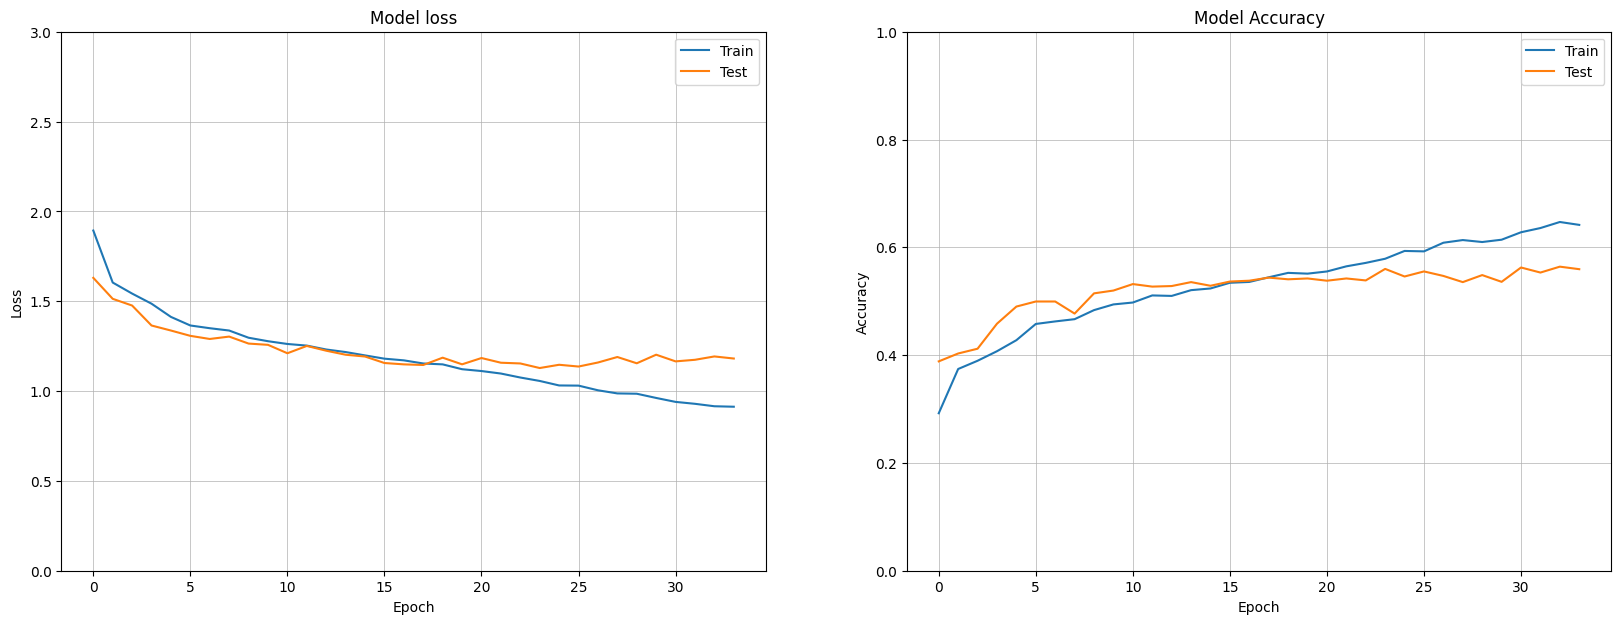

In [31]:
plot_loss_accuracy(history)